#0. Library, load data

In [1]:
!pip install optuna
!pip install shap
!pip install kagglehub

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import shap
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, recall_score, make_scorer, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import optuna
import warnings
import xgboost as xgb
from xgboost import XGBClassifier
import os
from torch.utils.data import DataLoader, TensorDataset
import kagglehub

warnings.filterwarnings('ignore')

In [3]:
# Download latest version
path = kagglehub.dataset_download("abhishek14398/loan-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Admin\.cache\kagglehub\datasets\abhishek14398\loan-dataset\versions\1


In [4]:
!ls $path

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
mainpath = path
data_dictionary_path = os.path.join(mainpath, 'Data_Dictionary.xlsx')
loan_path = os.path.join(mainpath, 'loan.csv')
loan_df = pd.read_csv(loan_path)
dict_df = pd.read_excel(data_dictionary_path)

#1. Data Understanding and Cleaning

In [6]:
print(f"Shape of the dataset: {loan_df.shape}")
print(f"Type of dataset: {loan_df.dtypes}")

Shape of the dataset: (39717, 111)
Type of dataset: id                              int64
member_id                       int64
loan_amnt                       int64
funded_amnt                     int64
funded_amnt_inv               float64
                               ...   
tax_liens                     float64
tot_hi_cred_lim               float64
total_bal_ex_mort             float64
total_bc_limit                float64
total_il_high_credit_limit    float64
Length: 111, dtype: object


In [7]:
# Kiểm tra dòng trùng lặp
print(loan_df.duplicated(subset=None, keep='first').count())

# Sử dụng cột id để kiểm tra
duplicate_rows = loan_df[loan_df.duplicated(['id'])]
print("duplicate_rows :", duplicate_rows)

39717
duplicate_rows : Empty DataFrame
Columns: [id, member_id, loan_amnt, funded_amnt, funded_amnt_inv, term, int_rate, installment, grade, sub_grade, emp_title, emp_length, home_ownership, annual_inc, verification_status, issue_d, loan_status, pymnt_plan, url, desc, purpose, title, zip_code, addr_state, dti, delinq_2yrs, earliest_cr_line, inq_last_6mths, mths_since_last_delinq, mths_since_last_record, open_acc, pub_rec, revol_bal, revol_util, total_acc, initial_list_status, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, next_pymnt_d, last_credit_pull_d, collections_12_mths_ex_med, mths_since_last_major_derog, policy_code, application_type, annual_inc_joint, dti_joint, verification_status_joint, acc_now_delinq, tot_coll_amt, tot_cur_bal, open_acc_6m, open_il_6m, open_il_12m, open_il_24m, mths_since_rcnt_il, total_bal_il, il_util, open_rv_12m, open_rv_24m, ma

In [8]:
# Kiểm tra tổng số dòng trùng lặp
loan_df.duplicated().sum()

0

In [9]:
# Xóa các cột rỗng hoàn toàn
loan_df = loan_df.dropna(axis=1, how='all')

In [10]:
# Tìm số lượng hàng có tất cả các giá trị là rỗng
print('Number of rows having all values as null:')
print(loan_df.isnull().all(axis=1).sum())

# Tìm số lượng cột có tất cả các giá trị là rỗng
print('Number of columns having all values as null:')
print(loan_df.isnull().all(axis=0).sum())

Number of rows having all values as null:
0
Number of columns having all values as null:
0


In [11]:
# In ra dữ liệu không nhất quán
numeric = loan_df.select_dtypes(include=np.number)
(numeric.values < 0).sum()

0

In [12]:
# Loại bỏ ký hiệu % trong cột 'int_rate' và 'revol_util' để thêm vào trong phân tích
loan_df['int_rate'] = loan_df['int_rate'].str.rstrip('%').astype(float)
loan_df['revol_util'] = loan_df['revol_util'].str.rstrip('%').astype(float)

- Loại bỏ ký hiệu % trong cột 'int_rate' và 'revol_util' do các cột 'int_rate' và 'revol_util' cần thiết cho việc huấn luyện mô hình.
- 'int_rate' là tỷ lệ lãi suất ngân hàng, lãi suất cao sẽ ảnh hưởng đến khả năng có trả nợ hay không. 
- 'revol_util' là tỷ lệ sử dụng nợ tín dụng, thể hiện khả năng tự mình trả nợ của khách hàng.

In [13]:
loan_df['emp_length'] = loan_df.emp_length.str.extract('(\d+)')
# Chuyển đổi các cột dữ liệu số thành kiểu numeric
columns1 = ['loan_amnt', 'funded_amnt', 'int_rate', 'funded_amnt_inv',
            'installment', 'annual_inc', 'dti', 'emp_length', 'total_pymnt']
loan_df[columns1] = loan_df[columns1].apply(pd.to_numeric)

In [14]:
# Loại bỏ giá trị 'Current' trong cột 'loan_status' do vẫn còn trong thời hạn mượn nợ
loan_df = loan_df[loan_df.loan_status != "Current"]

- Do cột 'loan_status' sẽ được sử dụng làm target để xác định có nên đồng thuận khoản vay đó hay không, ta nên tập trung vào việc người đó trả hết nợ hoặc không có khả năng trả để từ đó dự đoán.

In [15]:
loan_df.loan_status.value_counts()

loan_status
Fully Paid     32950
Charged Off     5627
Name: count, dtype: int64

In [16]:
# Điền giá trị 0 cho các dòng Null trong cột 'pub_rec_bankruptcies'
loan_df['pub_rec_bankruptcies'].fillna(0, inplace=True)

# Kiểm tra số lượng giá trị Null trong cột 'pub_rec_bankruptcies'
loan_df['pub_rec_bankruptcies'].isnull().sum()

0

In [17]:
# Tính tỷ lệ giá trị thiếu cho mỗi cột
missing_values = loan_df.isnull().mean() * 100

# Xác định các cột có tỷ lệ giá trị thiếu lớn hơn 10%
cols_to_drop = missing_values[missing_values > 10].index

# Xóa các cột này khỏi DataFrame
loan_df = loan_df.drop(columns=cols_to_drop)

# Hiển thị các cột đã bị xóa
print(f"Deleted cols: {cols_to_drop.tolist()}")

Deleted cols: ['desc', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d']


- Xóa các cột ['desc', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d'] do các dữ liệu Null được dự đoán bởi thuật toán MICE không đáng tin vì chứa nhiều missing value. 

In [18]:
# Sử dụng IterativeImputer để điền các giá trị Null
imputer = IterativeImputer(random_state=100, max_iter=10)
df2 = loan_df.select_dtypes(exclude='object')
imputer.fit(df2)
df_imputed = imputer.transform(df2)
df_imputed[:10]
df_imputed = pd.DataFrame(df_imputed, columns=df2.columns)
df = loan_df.drop(columns=df2.columns)
loan_df = pd.concat([df_imputed, df], axis=1)

#2. Feature selection & visualization

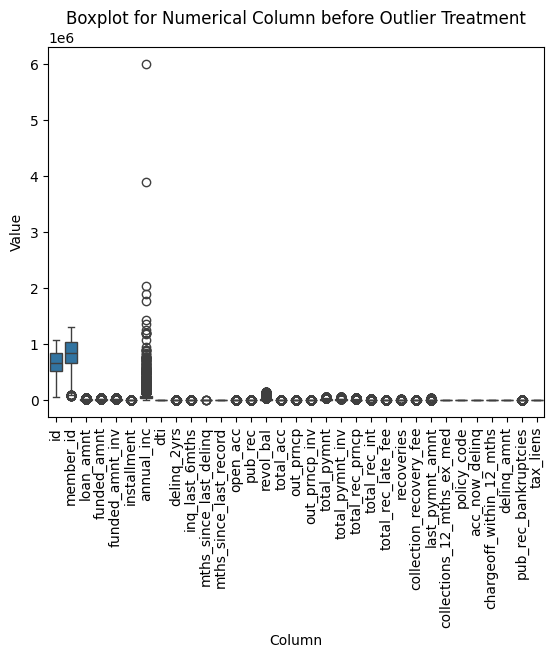

In [19]:
# Vẽ biểu đồ boxplot thể hiện các giá trị ngoại lai
numeric = pd.melt(numeric, var_name='Column', value_name='Value')
sns.boxplot(data=numeric, x='Column', y='Value')
plt.title("Boxplot for Numerical Column before Outlier Treatment")
plt.xticks(rotation=90)
plt.show()

In [20]:
# Hàm loại bỏ các giá trị ngoại lai
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Tính các khoảng giới hạn
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Xóa các dòng có giá trị nằm ngoài khoảng
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df_cleaned

In [21]:
# Do cột 'annual_inc' có nhiều giá trị ngoại lai nên ta sẽ remove
loan_df = remove_outliers(loan_df, 'annual_inc')

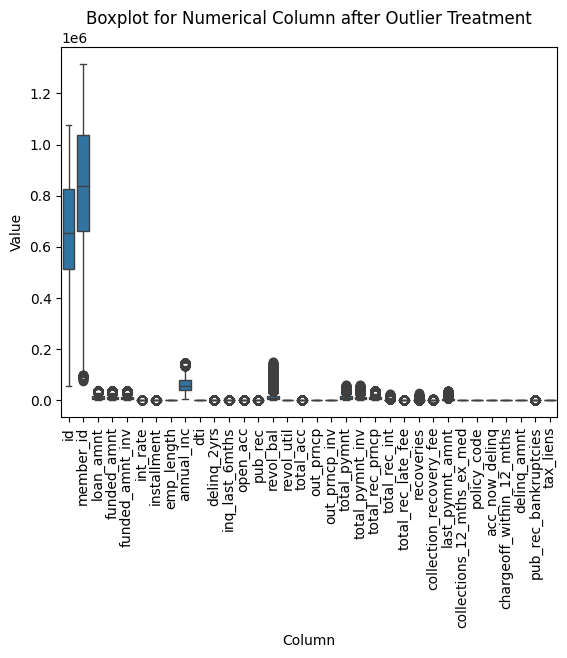

In [22]:
numeric = pd.melt(loan_df.select_dtypes(exclude='object'),
                  var_name='Column', value_name='Value')
sns.boxplot(data=numeric, x='Column', y='Value')
plt.title("Boxplot for Numerical Column after Outlier Treatment")
plt.xticks(rotation=90)
plt.show()

In [23]:
loan_df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,emp_length,annual_inc,dti,...,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
count,3.681500e+04,3.681500e+04,36815.000000,36815.000000,36815.000000,36815.000000,36815.000000,36815.000000,36815.000000,36815.000000,...,36815.000000,36815.000000,36815.000000,36815.0,36815.0,36815.0,36815.0,36815.0,36815.000000,36815.0
mean,6.760857e+05,8.419800e+05,10706.984925,10460.175200,9916.487115,11.889882,312.593015,5.026362,61218.193490,13.437614,...,95.148365,12.176062,2634.677276,0.0,1.0,0.0,0.0,0.0,0.043787,0.0
std,2.091882e+05,2.643366e+05,7068.107909,6820.737715,6750.340900,3.668709,199.806808,3.347519,28224.583784,6.660651,...,680.688516,145.441890,4313.178379,0.0,0.0,0.0,0.0,0.0,0.205285,0.0
min,5.473400e+04,7.472400e+04,500.000000,500.000000,0.000000,5.420000,15.690000,1.000000,4000.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0
25%,5.122775e+05,6.614220e+05,5000.000000,5000.000000,4988.984523,8.940000,163.305000,2.000000,40000.000000,8.340000,...,0.000000,0.000000,212.730000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0
50%,6.556460e+05,8.378840e+05,9250.000000,9000.000000,8400.000000,11.710000,271.140000,4.000000,56000.000000,13.570000,...,0.000000,0.000000,546.160000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0
75%,8.278755e+05,1.035967e+06,15000.000000,14400.000000,13687.858570,14.270000,409.700000,8.000000,78000.000000,18.700000,...,0.000000,0.000000,3312.680000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0
max,1.077501e+06,1.314167e+06,35000.000000,35000.000000,35000.000000,24.400000,1305.190000,10.000000,145000.000000,29.990000,...,29623.350000,7002.190000,36115.200000,0.0,1.0,0.0,0.0,0.0,2.000000,0.0


In [24]:
# Tính phần trăm dựa vào mục đích vay
(loan_df.purpose.value_counts() * 100) / len(loan_df)

purpose
debt_consolidation    45.476029
credit_card           12.614423
other                  9.542306
home_improvement       7.266060
major_purchase         5.508624
small_business         4.400380
car                    3.805514
wedding                2.319707
medical                1.727557
moving                 1.469510
vacation               0.947983
house                  0.947983
educational            0.752411
renewable_energy       0.258047
Name: count, dtype: float64

In [25]:
# Bỏ các cột dưới đây vì các dữ liệu không ảnh hưởng đến việc dự đoán
columns_to_drop = ["id", "member_id", "application_type", "policy_code", "initial_list_status",
                   "installment", "pymnt_plan", "addr_state", "grade", "url", "collections_12_mths_ex_med", "acc_now_delinq"]
loan_df = loan_df.drop(
    columns=[col for col in columns_to_drop if col in loan_df.columns])

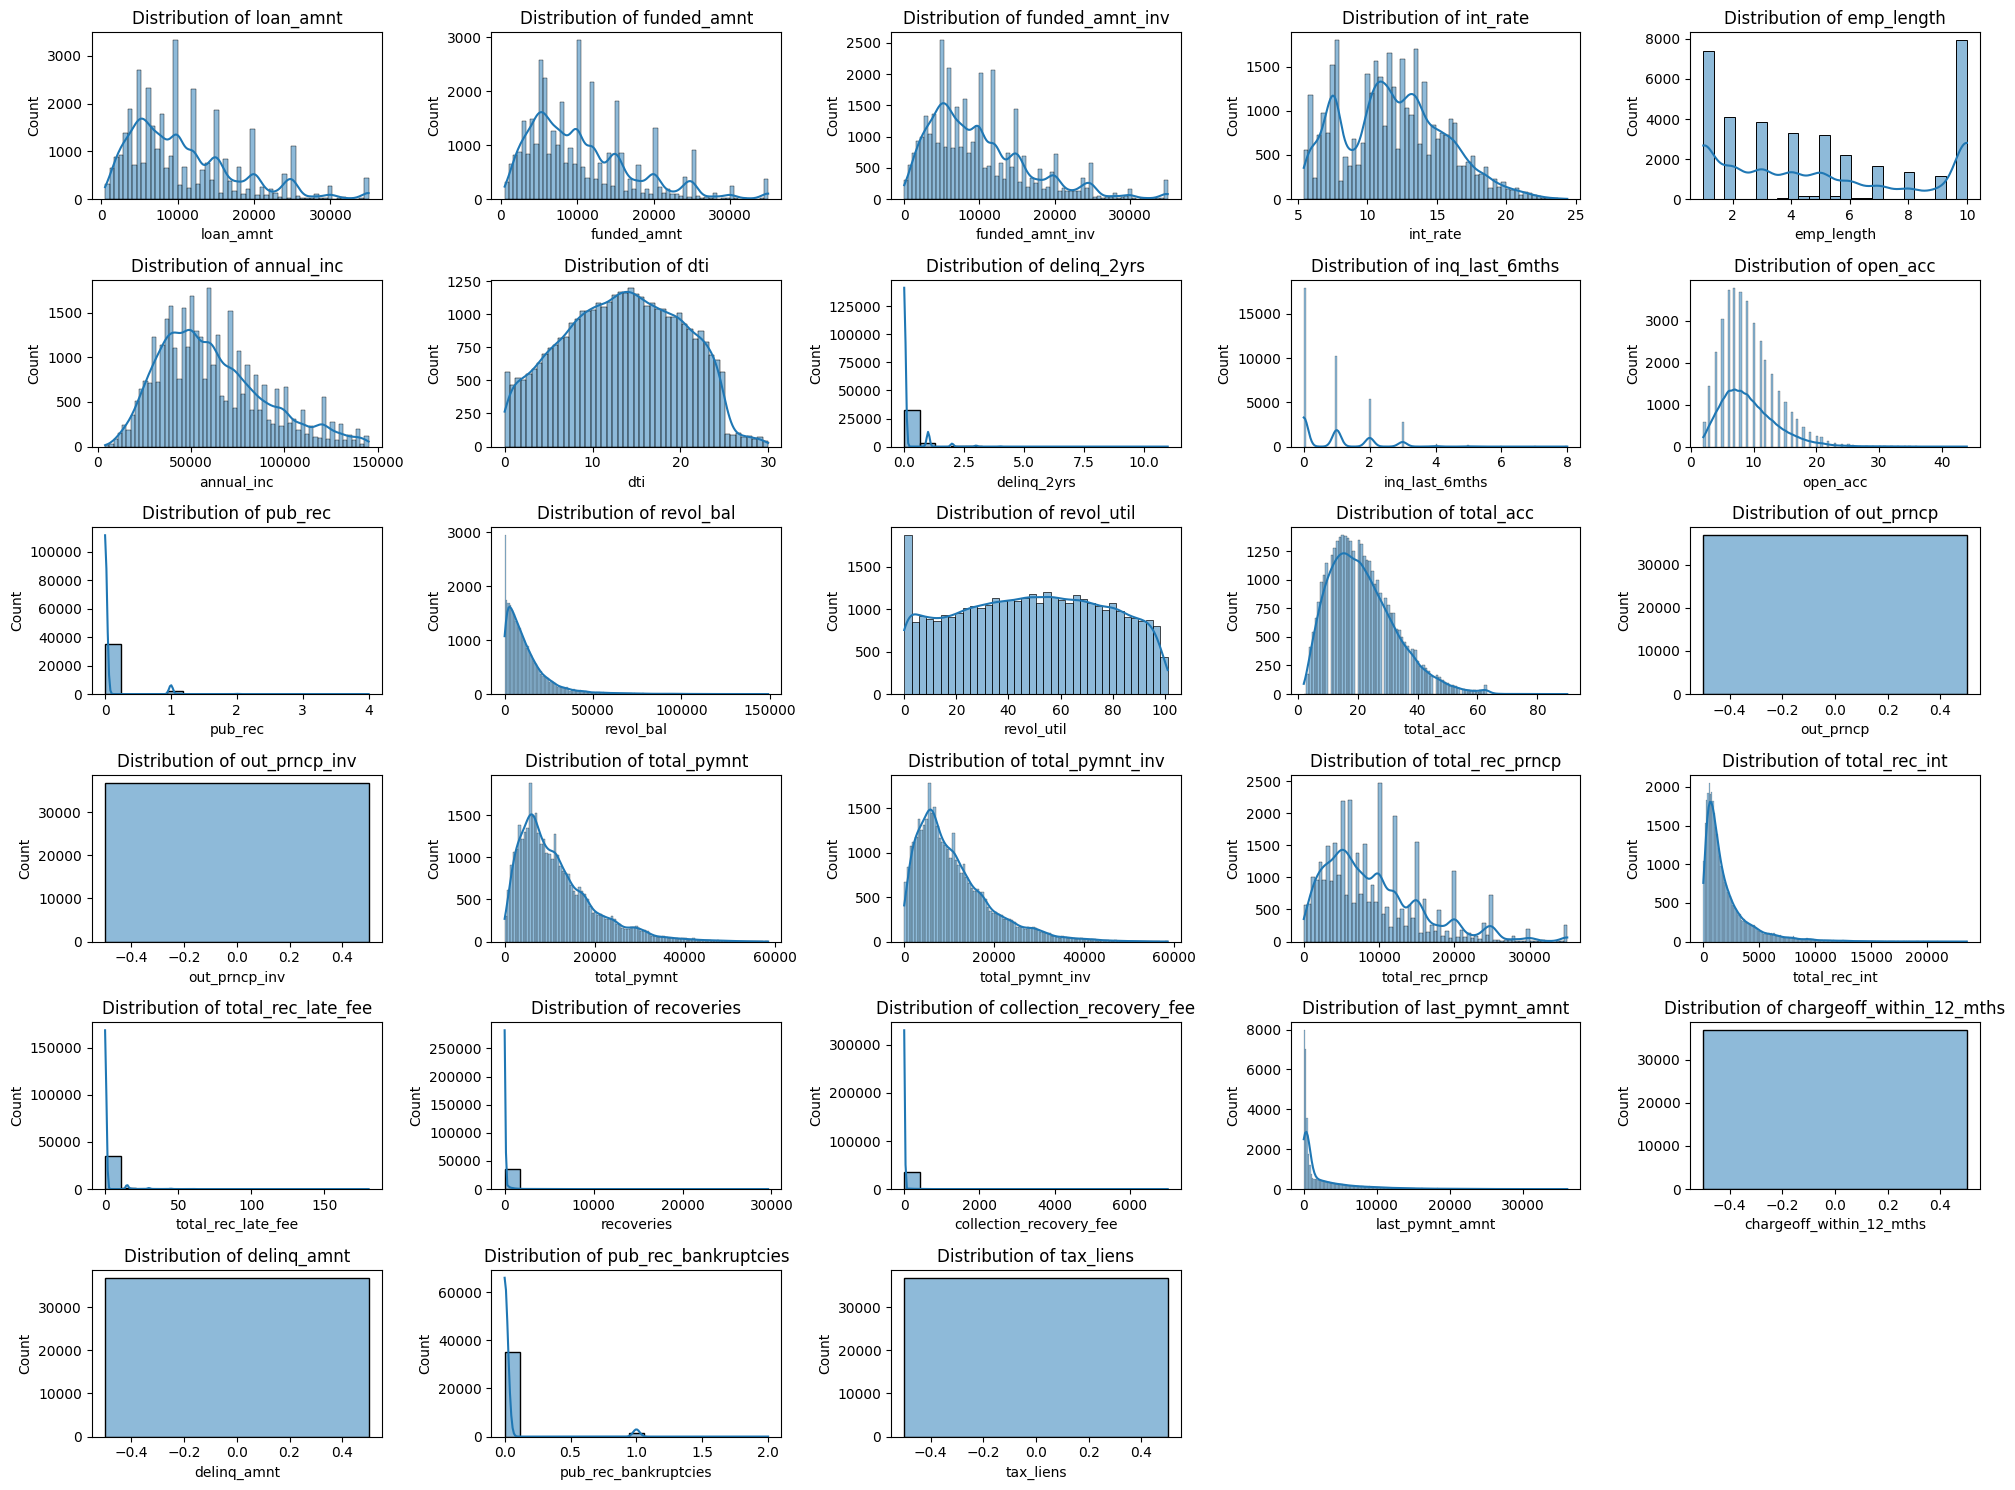

In [26]:
numerical_features = loan_df.select_dtypes(exclude='object').columns
# Vẽ đồ thị phân phối của các biến số
num_features = len(numerical_features)
num_cols = 5
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)

plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(loan_df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

In [27]:
# Bỏ các cột dưới đây vì các giá trị không đổi
columns_to_drop = ['out_prncp', 'out_prncp_inv',
                   'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens']
loan_df = loan_df.drop(
    columns=[col for col in columns_to_drop if col in loan_df.columns])

- Bỏ các cột trên vì các giá trị không đổi nên không ảnh hưởng đến dự đoán mô hình.

In [28]:
# Tiến hành Label encoding
label_encoder = LabelEncoder()
binary_cols = loan_df.select_dtypes(include=['object']).columns.intersection(['term', 'sub_grade', 'home_ownership',
                                                                             'verification_status', 'issue_d',
                                                                              'purpose', 'title', 'zip_code',
                                                                              'earliest_cr_line',
                                                                              'last_pymnt_d', 'last_credit_pull_d', 'emp_title'])
for col in binary_cols:
    loan_df[col] = label_encoder.fit_transform(loan_df[col])

for col in binary_cols:
    freq_encoding = loan_df[col].value_counts().to_dict()
    loan_df[col] = loan_df[col].map(freq_encoding)

- Thay giá trị 'Fully Paid' = 1, 'Charged Off' = 0 do nếu 1 người trả nợ thì có thể tiếp tục cho mượn và ngược lại.
- Nên lấy loan_status làm cột target cho model.

In [29]:
loan_df['loan_status'] = loan_df['loan_status'].map(
    {'Fully Paid': 1, 'Charged Off': 0})

In [30]:
# Điền các giá trị trống bằng giá trị median
loan_df = loan_df.fillna(loan_df.median())

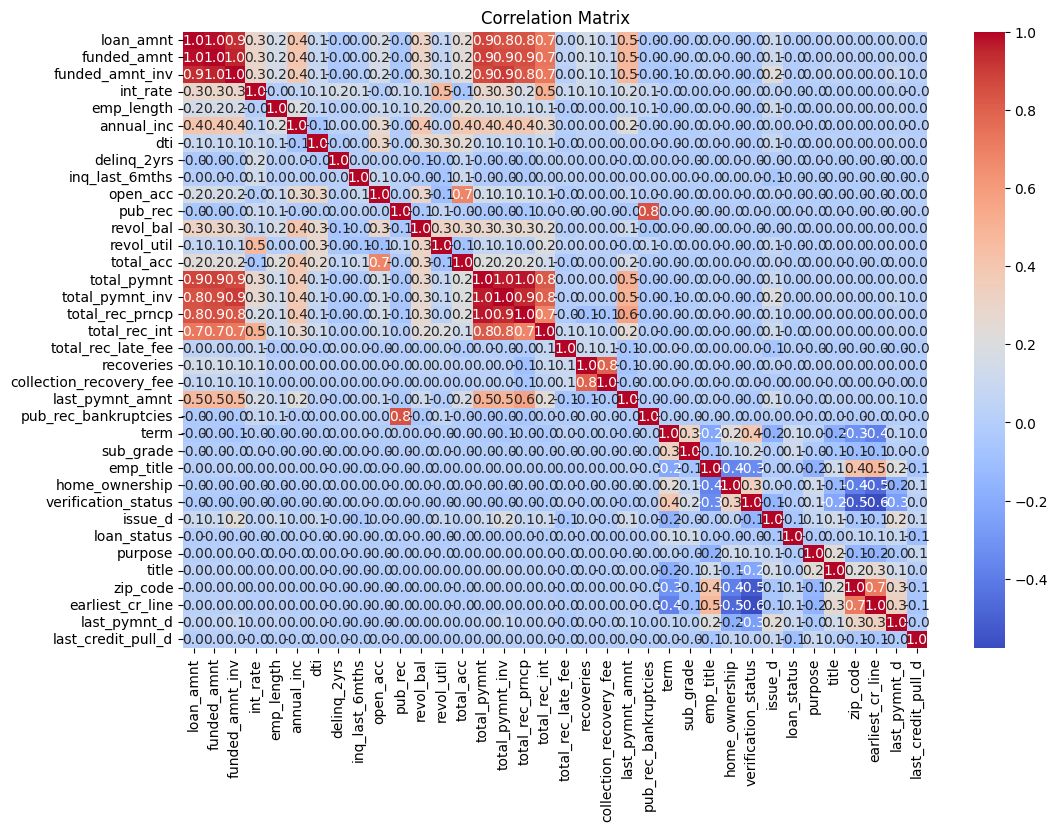

In [31]:
# Giả dụ cột 'loan_status' sẽ chỉ ra rằng khoản vay được chấp nhận hay không
# Mã hóa các giá trị biến trong 'loan_status'
loan_df['loan_status'] = loan_df['loan_status'].apply(
    lambda x: 1 if x == 1.0 else 0)

# Tính ma trận tương quan
correlation_matrix = loan_df.corr()

# Vẽ đồ thị heatmap cho ma trận tương quan
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Correlation Matrix')
plt.show()

- Từ hình ta thấy được sự tương quan giữa các feature với nhau, các feature có sự tương quan lớn nên có loại bỏ được 1 trong 2.

In [32]:
# Loại bỏ các cột có độ tương quan cao
columns_to_drop = ['funded_amnt_inv', 'total_pymnt_inv', 'issue_d']
loan_df = loan_df.drop(
    columns=[col for col in columns_to_drop if col in loan_df.columns])

Class Distribution of Loan Status:
loan_status
1    31627
0     5188
Name: count, dtype: int64


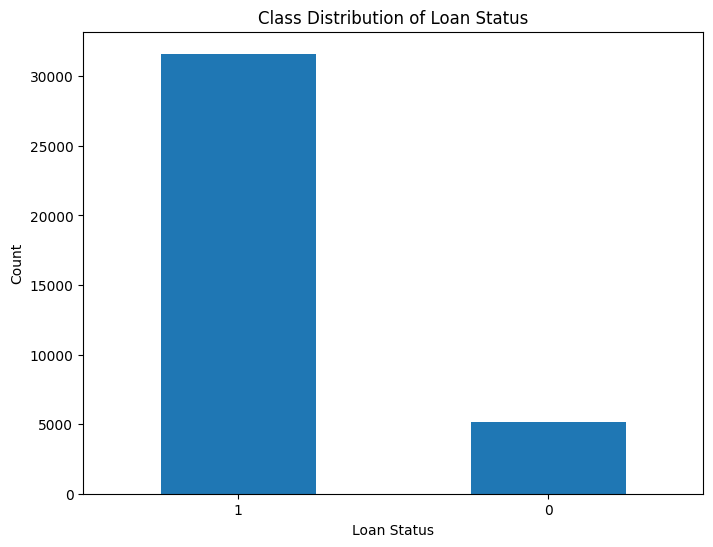

In [33]:
# Đếm các giá trị khác nhau trong 'loan_status'
loan_status_counts = loan_df['loan_status'].value_counts()

print("Class Distribution of Loan Status:")
print(loan_status_counts)

# Vẽ đồ thị phân phối cho từng lớp
plt.figure(figsize=(8, 6))
loan_status_counts.plot(kind='bar')
plt.title('Class Distribution of Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

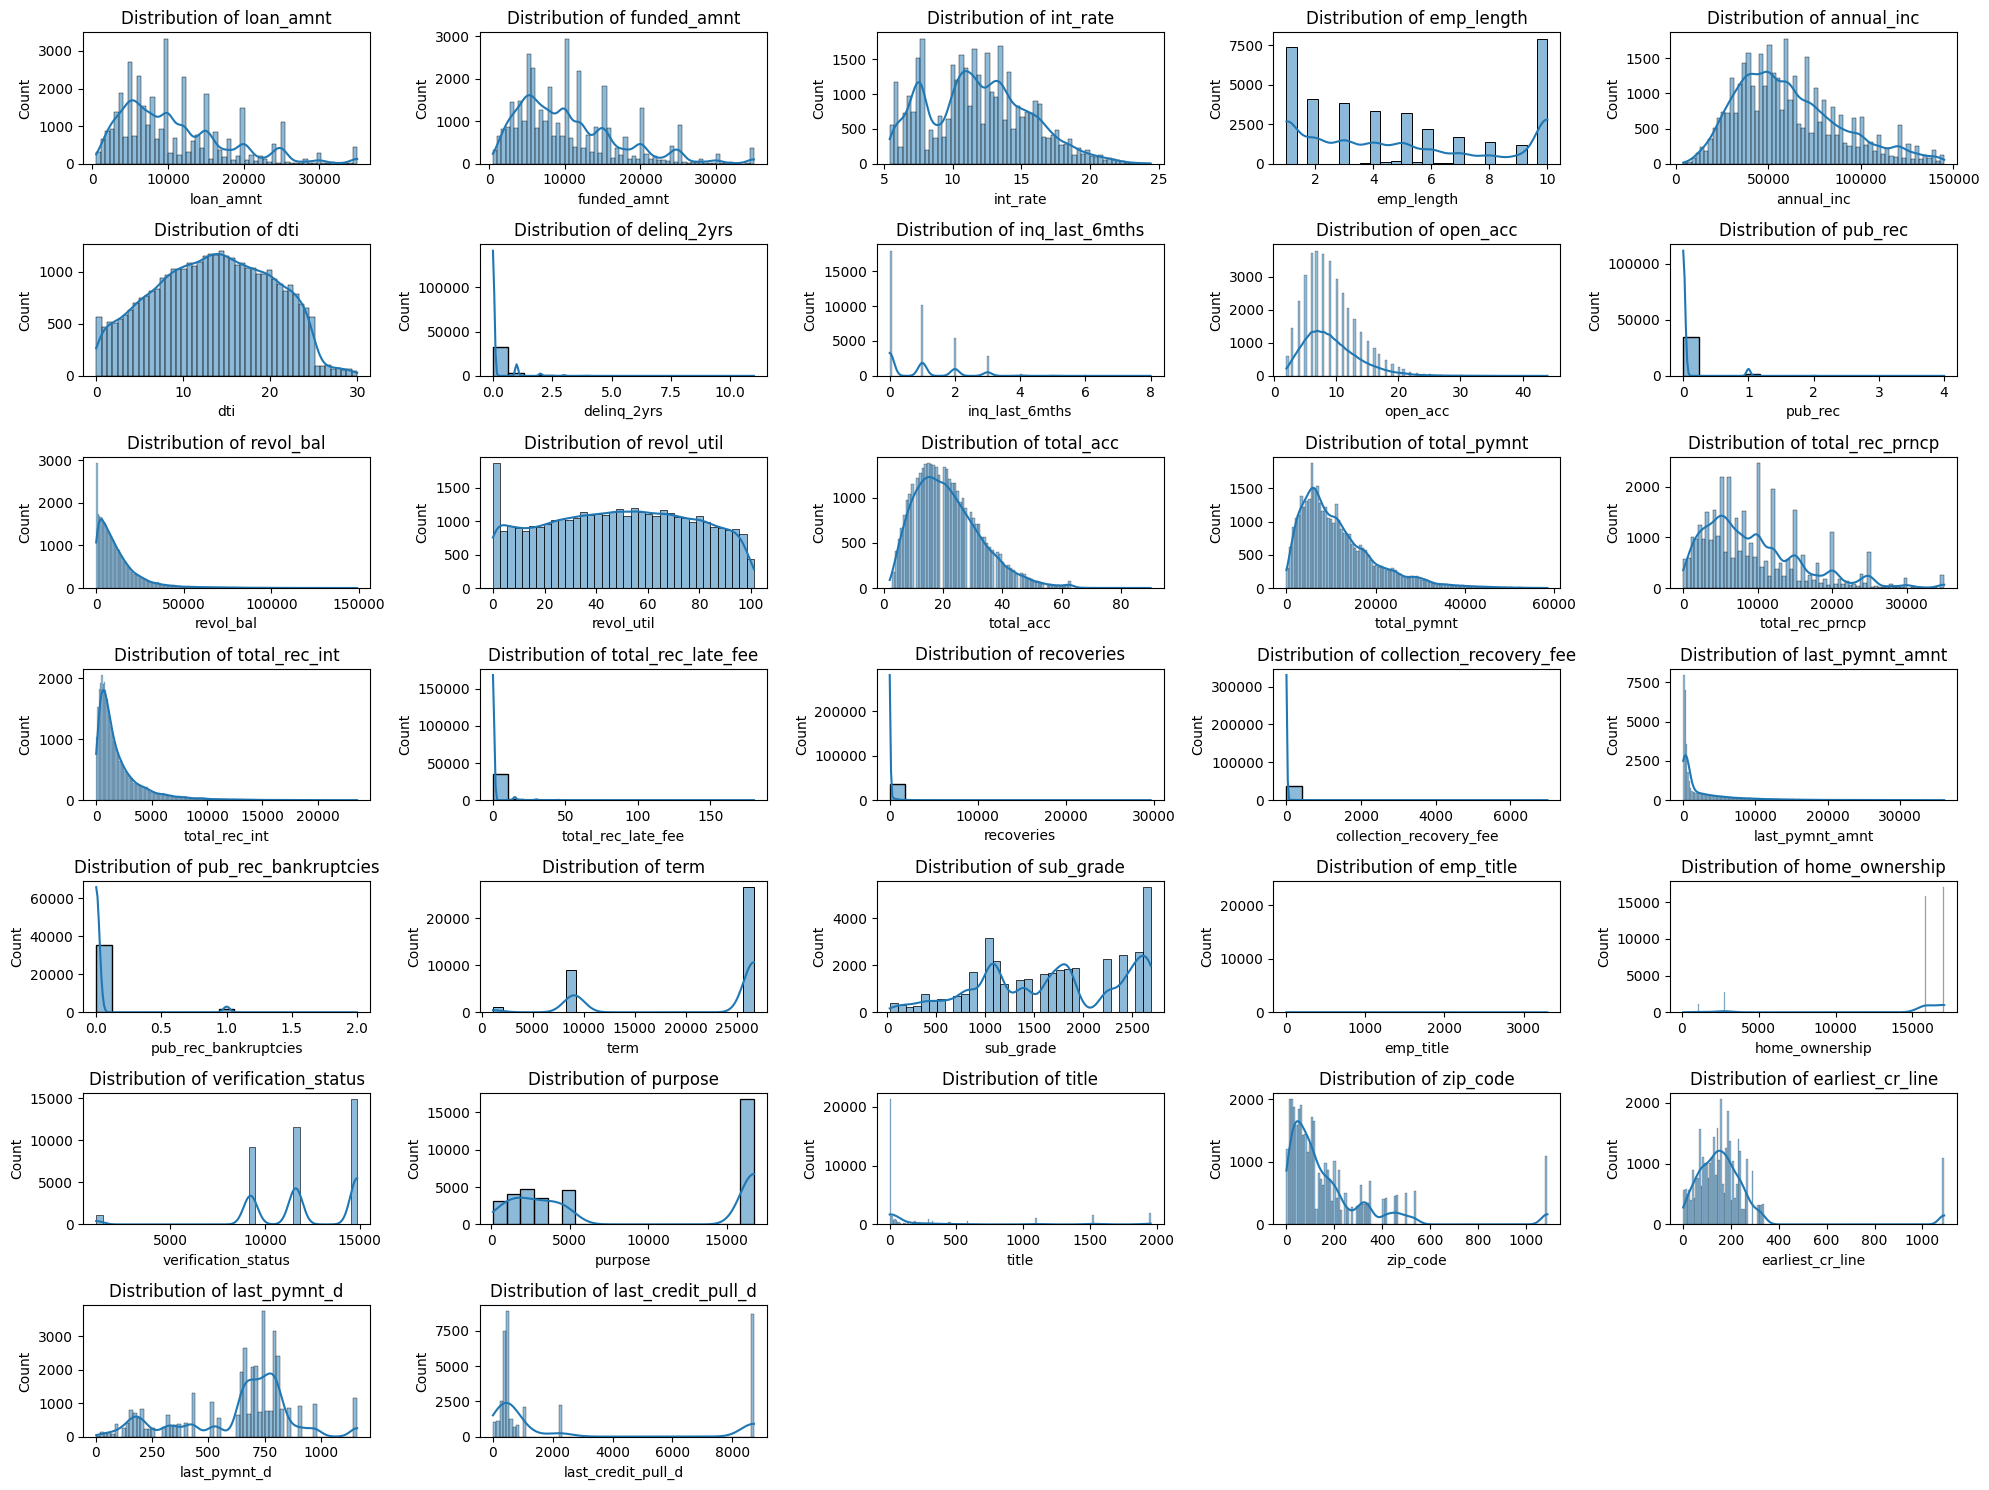

In [34]:
numerical_features = loan_df.drop(
    columns=['loan_status']).select_dtypes(exclude='object').columns


# Vẽ đồ thị phân phối cho các feature
num_features = len(numerical_features)

num_cols = 5

num_rows = (num_features // num_cols) + (num_features % num_cols > 0)


plt.figure(figsize=(20, 15))

for i, feature in enumerate(numerical_features):

    plt.subplot(num_rows, num_cols, i + 1)

    sns.histplot(loan_df[feature], kde=True)

    plt.title(f'Distribution of {feature}')

plt.tight_layout()

plt.show()

1. **Class Distribution**:
   - Analyze the balance of accepted vs. rejected loans được thực hiện bằng cách đếm số lần xuất hiện của Fully paid và Charged off.
   - Vẽ biểu đồ cột để trực quan hóa loan_status.

2. **Feature Distributions**:
   - Vẽ các biểu đồ cột thể hiện sự phân bố dữ liệu của từng feature. Từ đó, tập trung vào các feature có mật độ phân bố trải đều, ổn định như: dti, annual_inc, total_pymnt, total_acc...

3. **Correlation Analysis**:
   - Vẽ biểu đồ nhiệt để thể hiện sự tương quan của features qua correlation matrix, loại bỏ các feature có độ tương quan lớn.

4. **Missing Values**:
   - Dựa vào phần trăm các giá trị bị thiếu để lựa chọn feature phù hợp cho mô hình. 
   - Giữ lại các feature có phần trăm thiếu sót dưới 10% do các feature có ít sự liên kết với nhau.
   - Điền các giá trị thiếu bằng 2 cách:
      - Đối với numeric_features: sử dụng mô hình MICE để dự đoán.
      - Đối với categorical variables: encoding dữ liệu sau đó điền giá trị bị thiếu bằng median.

In [35]:
# Chuẩn bị dữ liệu
X = loan_df.drop(columns=['loan_status'])  # Features
y = loan_df['loan_status']  # Target

# Tách dữ liệu để huấn luyện
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

# II Model Development

## 1.Decision Tree

In [ ]:
# Create the Decision Tree model with class weight to minimize false positives
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

y_val_pred = dt_model.predict(X_val)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))

Confusion Matrix:
[[ 245  475]
 [ 500 3934]]

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.34      0.33       720
           1       0.89      0.89      0.89      4434

    accuracy                           0.81      5154
   macro avg       0.61      0.61      0.61      5154
weighted avg       0.81      0.81      0.81      5154


Accuracy Score:
0.810826542491269
ROC AUC Score:
0.6137563900165388


In [ ]:
# Predict on the validation set
y_test_pred = dt_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_test_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_test_pred))

Confusion Matrix:
[[ 512 1051]
 [1091 8391]]

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.33      0.32      1563
           1       0.89      0.88      0.89      9482

    accuracy                           0.81     11045
   macro avg       0.60      0.61      0.61     11045
weighted avg       0.81      0.81      0.81     11045


Accuracy Score:
0.8060660932548664
ROC AUC Score:
0.6062575310218384


### Hyperparameter Tunning

In [ ]:
# Hàm mục tiêu
def objective(trial):
    # Tham số để tối ưu hóa
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    # Mô hình Decision Tree
    dt_model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=42,
        class_weight='balanced'
    )

    # Tính Recall của lớp 0 với Cross-Validation
    recall_scores = cross_val_score(
        dt_model, X_train, y_train,
        cv=5, scoring=make_scorer(recall_score, pos_label=0)
    )

    # Trả về Recall trung bình
    return recall_scores.mean()

In [ ]:
study = optuna.create_study(direction='maximize')  # Tối đa hóa Recall lớp 0
study.optimize(objective, n_trials=50)  # Thử nghiệm 50 lần

# Kết quả tốt nhất
print("Best parameters:", study.best_params)
print("Best recall for class 0:", study.best_value)

[I 2024-11-30 14:08:39,088] A new study created in memory with name: no-name-71576a86-220c-4731-b119-cb01cda5fc9e
[I 2024-11-30 14:08:40,132] Trial 0 finished with value: 0.6165232358003443 and parameters: {'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 9, 'criterion': 'gini'}. Best is trial 0 with value: 0.6165232358003443.
[I 2024-11-30 14:08:43,514] Trial 1 finished with value: 0.5697074010327022 and parameters: {'max_depth': 13, 'min_samples_split': 12, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6165232358003443.
[I 2024-11-30 14:08:48,095] Trial 2 finished with value: 0.5180722891566265 and parameters: {'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 0 with value: 0.6165232358003443.
[I 2024-11-30 14:08:50,322] Trial 3 finished with value: 0.5755593803786574 and parameters: {'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 0 wi

Best parameters: {'max_depth': 8, 'min_samples_split': 17, 'min_samples_leaf': 9, 'criterion': 'gini'}
Best recall for class 0: 0.6561101549053356


In [ ]:
best_params = study.best_params
dt_model = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    criterion=best_params['criterion'],
    class_weight='balanced',
    random_state=42
)

dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=9,
                       min_samples_split=17, random_state=42)

In [ ]:
y_train_pred = dt_model.predict(X_train)
print("Train Set:")
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred))

Train Set:
Confusion Matrix:
[[ 2169   736]
 [ 4339 13372]]

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.75      0.46      2905
           1       0.95      0.76      0.84     17711

    accuracy                           0.75     20616
   macro avg       0.64      0.75      0.65     20616
weighted avg       0.86      0.75      0.79     20616



In [ ]:
# Predict on the validation set
y_val_pred = dt_model.predict(X_val)
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))
# Predict on the test set
y_test_pred = dt_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_test_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_test_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.64      0.39       720
           1       0.93      0.74      0.82      4434

    accuracy                           0.72      5154
   macro avg       0.60      0.69      0.61      5154
weighted avg       0.84      0.72      0.76      5154


Accuracy Score:
0.7239037640667443
ROC AUC Score:
0.6882987520673582

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.65      0.40      1563
           1       0.93      0.74      0.82      9482

    accuracy                           0.72     11045
   macro avg       0.61      0.69      0.61     11045
weighted avg       0.84      0.72      0.76     11045


Accuracy Score:
0.7242191036668175
ROC AUC Score:
0.6945758289640079


### Feature Selection

In [ ]:
# Lấy trọng số của từng feature
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
# Hiển thị các đặc trưng quan trọng
print("Feature Importances:")
print(feature_importances.head(20))

Feature Importances:
               Feature  Importance
30        last_pymnt_d    0.341788
31  last_credit_pull_d    0.243737
22           sub_grade    0.143095
21                term    0.122966
28            zip_code    0.018882
2             int_rate    0.014202
19     last_pymnt_amnt    0.012687
5                  dti    0.012097
29    earliest_cr_line    0.010921
23           emp_title    0.009919
24      home_ownership    0.007817
4           annual_inc    0.007675
11          revol_util    0.007447
10           revol_bal    0.005587
14     total_rec_prncp    0.005394
12           total_acc    0.005350
8             open_acc    0.004939
0            loan_amnt    0.004854
13         total_pymnt    0.004510
1          funded_amnt    0.004276


In [ ]:
threshold = 0.03
selected_features = feature_importances[feature_importances['Importance'] > threshold]
selected_features

,Feature,Importance
30,last_pymnt_d,0.341788
31,last_credit_pull_d,0.243737
22,sub_grade,0.143095
21,term,0.122966


In [ ]:
# Lấy danh sách các feature từ selected_features
selected_feature_names = selected_features['Feature'].tolist()

# Lọc X_train chỉ giữ lại các feature trong selected_feature_names
X_train_selected = X_train[selected_feature_names]
X_val_selected = X_val[selected_feature_names]
X_test_selected = X_test[selected_feature_names]

# Hiển thị các cột đã được chọn
print(X_train_selected.columns)

Index(['last_pymnt_d', 'last_credit_pull_d', 'sub_grade', 'term'], dtype='object')


In [ ]:
X_val_selected_dict["decision tree"] = X_val_selected

In [ ]:
# Train the model
dt_model.fit(X_train_selected, y_train)

y_val_pred = dt_model.predict(X_val_selected)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))

Confusion Matrix:
[[ 479  241]
 [1040 3394]]

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.67      0.43       720
           1       0.93      0.77      0.84      4434

    accuracy                           0.75      5154
   macro avg       0.62      0.72      0.63      5154
weighted avg       0.85      0.75      0.78      5154


Accuracy Score:
0.7514551804423748
ROC AUC Score:
0.7153632912344009


In [ ]:
y_test_pred = dt_model.predict(X_test_selected)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_test_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_test_pred))

Confusion Matrix:
[[1069  494]
 [2276 7206]]

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.68      0.44      1563
           1       0.94      0.76      0.84      9482

    accuracy                           0.75     11045
   macro avg       0.63      0.72      0.64     11045
weighted avg       0.85      0.75      0.78     11045


Accuracy Score:
0.7492077863286555
ROC AUC Score:
0.7219536953405873


## 2.Logistic Regression Model

In [ ]:
logistic_model = LogisticRegression(
    class_weight='balanced', random_state=42, penalty='l2', solver='liblinear')

logistic_model.fit(X_train, y_train)

y_val_pred = logistic_model.predict(X_val)
print("Validation Set:")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))

Validation Set:
Confusion Matrix:
[[ 449  271]
 [1488 2946]]

Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.62      0.34       720
           1       0.92      0.66      0.77      4434

    accuracy                           0.66      5154
   macro avg       0.57      0.64      0.55      5154
weighted avg       0.82      0.66      0.71      5154


Accuracy Score:
0.6587116802483508
ROC AUC Score:
0.644011238911442


### Hyperparameter Tunning

In [ ]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300],
    'class_weight': ['balanced']
}

In [ ]:
# Tạo đối tượng LogisticRegression
model = LogisticRegression()

# Sử dụng GridSearchCV để tìm các tham số tốt nhất
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=make_scorer(
    recall_score, pos_label=0), cv=5, n_jobs=-1)

# Huấn luyện mô hình
grid_search.fit(X_train, y_train)

# In ra các tham số tốt nhất
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
# Dự đoán và đánh giá mô hình
logistic_regression = grid_search.best_estimator_
y_pred = logistic_regression.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.61      0.34      1563
           1       0.91      0.67      0.77      9482

    accuracy                           0.66     11045
   macro avg       0.57      0.64      0.56     11045
weighted avg       0.82      0.66      0.71     11045

Accuracy Score:
0.6636487098234495
ROC AUC Score:
0.6427341605463724


In [ ]:
y_val_pred = logistic_regression.predict(X_val)

# Evaluate the model
print("Validation Set:")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))

Validation Set:
Confusion Matrix:
[[ 450  270]
 [1454 2980]]

Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.62      0.34       720
           1       0.92      0.67      0.78      4434

    accuracy                           0.67      5154
   macro avg       0.58      0.65      0.56      5154
weighted avg       0.82      0.67      0.72      5154


Accuracy Score:
0.6655025223127667
ROC AUC Score:
0.6485396932792062


### Feature Selection

In [ ]:
weights = logistic_regression.coef_[0]

# Tạo DataFrame chứa các feature và trọng số tương ứng
weights_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Weight': weights
})

# Sắp xếp theo trọng số giảm dần
weights_df = weights_df.sort_values(by='Weight', ascending=False)

# Hiển thị các feature quan trọng
print("Feature Weights:")
print(weights_df.head(20))

Feature Weights:
                 Feature        Weight
20  pub_rec_bankruptcies  1.951366e-02
9                pub_rec  1.652549e-02
16    total_rec_late_fee  4.271861e-03
29      earliest_cr_line  1.351388e-03
13           total_pymnt  1.094194e-03
28              zip_code  7.620824e-04
30          last_pymnt_d  4.590996e-04
22             sub_grade  3.473815e-04
21                  term  4.286423e-05
0              loan_amnt  4.167881e-05
27                 title  3.948270e-05
19       last_pymnt_amnt  1.732480e-05
10             revol_bal  3.783994e-06
4             annual_inc  1.835264e-07
26               purpose -5.587838e-06
24        home_ownership -3.050381e-05
25   verification_status -4.962084e-05
1            funded_amnt -5.015014e-05
31    last_credit_pull_d -7.507070e-05
23             emp_title -1.420747e-04


In [ ]:
feature_weights = logistic_regression.coef_[0]

# Chọn đặc trưng có trọng số lớn (chẳng hạn chỉ chọn những đặc trưng có trọng số > 0)
selected_features = np.abs(feature_weights) > 1e-5  # Ngưỡng có thể thay đổi

# Chọn ra X_train_selected
X_train_selected = X_train.loc[:, selected_features]

# In ra các đặc trưng được chọn
print("Selected Features:", X_train.columns[selected_features])

# In ra X_train_selected
print("X_train_selected shape:", X_train_selected.shape)

Selected Features: Index(['loan_amnt', 'funded_amnt', 'int_rate', 'emp_length', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util',
       'total_acc', 'total_pymnt', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'pub_rec_bankruptcies', 'term', 'sub_grade',
       'emp_title', 'home_ownership', 'verification_status', 'title',
       'zip_code', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'],
      dtype='object')
X_train_selected shape: (20616, 29)


In [ ]:
X_val_selected = X_val.loc[:, selected_features]
X_test_selected = X_test.loc[:, selected_features]

In [ ]:
X_val_selected_dict["logistic"] = X_val_selected

In [ ]:
logistic_regression.fit(X_train_selected, y_train)

y_val_pred = logistic_regression.predict(X_val_selected)

# Evaluate the model
print("Validation Set:")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))

Validation Set:
Confusion Matrix:
[[ 451  269]
 [1455 2979]]

Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.63      0.34       720
           1       0.92      0.67      0.78      4434

    accuracy                           0.67      5154
   macro avg       0.58      0.65      0.56      5154
weighted avg       0.82      0.67      0.72      5154


Accuracy Score:
0.6655025223127667
ROC AUC Score:
0.6491213727259058


## 3.XGBoost

In [36]:
scale_pos_weight= 720/4434  #Tạo trọng số cho mô hình XGBoost
# 720 là số lượng mẫu negative, 4434 là số lượng mẫu positive

In [40]:
#Tạo XGBoost model với tham số cơ bản
XGmodel = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, subsample=0.8,scale_pos_weight=scale_pos_weight)
XGmodel.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

[0]	validation_0-logloss:0.67687
[1]	validation_0-logloss:0.65949
[2]	validation_0-logloss:0.64278
[3]	validation_0-logloss:0.63124
[4]	validation_0-logloss:0.62004
[5]	validation_0-logloss:0.61181
[6]	validation_0-logloss:0.60217
[7]	validation_0-logloss:0.59442
[8]	validation_0-logloss:0.58997
[9]	validation_0-logloss:0.58502
[10]	validation_0-logloss:0.57960
[11]	validation_0-logloss:0.57675
[12]	validation_0-logloss:0.57423
[13]	validation_0-logloss:0.56926
[14]	validation_0-logloss:0.56755
[15]	validation_0-logloss:0.56570
[16]	validation_0-logloss:0.56308
[17]	validation_0-logloss:0.56118
[18]	validation_0-logloss:0.55859
[19]	validation_0-logloss:0.55519
[20]	validation_0-logloss:0.55132
[21]	validation_0-logloss:0.54873
[22]	validation_0-logloss:0.54692
[23]	validation_0-logloss:0.54574
[24]	validation_0-logloss:0.54238
[25]	validation_0-logloss:0.53969
[26]	validation_0-logloss:0.53710
[27]	validation_0-logloss:0.53556
[28]	validation_0-logloss:0.53425
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [41]:
y_val_pred = XGmodel.predict(X_val)

# Evaluate the model
print("Validation Set:")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))


Validation Set:
Confusion Matrix:


[[ 497  223]
 [ 797 3637]]

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.69      0.49       720
           1       0.94      0.82      0.88      4434

    accuracy                           0.80      5154
   macro avg       0.66      0.76      0.69      5154
weighted avg       0.86      0.80      0.82      5154


Accuracy Score:
0.8020954598370198
ROC AUC Score:
0.755265185686363


In [42]:
y_test_pred = XGmodel.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_test_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_test_pred))

Confusion Matrix:
[[1065  498]
 [1714 7768]]

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.68      0.49      1563
           1       0.94      0.82      0.88      9482

    accuracy                           0.80     11045
   macro avg       0.66      0.75      0.68     11045
weighted avg       0.86      0.80      0.82     11045


Accuracy Score:
0.7997283838841105
ROC AUC Score:
0.750309202890131


### Hyperparameter

In [60]:
# Hàm objective cho Optuna
def objective(trial):
    # Các siêu tham số cần tối ưu
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.15, 1.0),  # Tối ưu trọng số lớp âm 
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
    }
    
    # Khởi tạo mô hình
    model = XGBClassifier(**params, use_label_encoder=False, eval_metric="auc")
    
    # Huấn luyện
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    # Tính recall của lớp 0 với Cross-Validation
    recall = cross_val_score(
        model, X_train, y_train,
        cv=5, scoring=make_scorer(recall_score, pos_label=0)
    )
    return recall.mean()

# Khởi tạo Optuna study và tìm siêu tham số tốt nhất
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Kết quả tốt nhất
print("Best Trial:")
print(study.best_trial.params)

[I 2024-12-04 20:39:26,812] A new study created in memory with name: no-name-00050ce9-15e4-4336-b049-7e5574b4e32e
[I 2024-12-04 20:39:32,439] Trial 0 finished with value: 0.327710843373494 and parameters: {'n_estimators': 437, 'max_depth': 7, 'learning_rate': 0.06645339028801779, 'subsample': 0.8756585523207077, 'colsample_bytree': 0.7480451102453252, 'scale_pos_weight': 0.6029398137535928, 'gamma': 1.6178573833690446, 'min_child_weight': 8}. Best is trial 0 with value: 0.327710843373494.
[I 2024-12-04 20:39:38,915] Trial 1 finished with value: 0.4623063683304647 and parameters: {'n_estimators': 386, 'max_depth': 5, 'learning_rate': 0.010627011417226322, 'subsample': 0.6177102661978834, 'colsample_bytree': 0.911311341828875, 'scale_pos_weight': 0.33168147084624977, 'gamma': 1.0069780385178366, 'min_child_weight': 1}. Best is trial 1 with value: 0.4623063683304647.
[I 2024-12-04 20:39:44,085] Trial 2 finished with value: 0.2640275387263339 and parameters: {'n_estimators': 589, 'max_dept

Best Trial:
{'n_estimators': 880, 'max_depth': 9, 'learning_rate': 0.0970049026111899, 'subsample': 0.6021038134542523, 'colsample_bytree': 0.5563395147691081, 'scale_pos_weight': 0.15104144451224208, 'gamma': 3.2763280467895934, 'min_child_weight': 5}


In [61]:
# Lấy các tham số tốt nhất từ quá trình tối ưu hóa
best_params = study.best_params

# Tạo mô hình XGBoost với các tham số tốt nhất
XGmodel_optimized = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    scale_pos_weight=best_params['scale_pos_weight'],
    gamma=best_params['gamma'],
    min_child_weight=best_params['min_child_weight'],
    use_label_encoder=False,
)

# Huấn luyện mô hình với tập huấn luyện
XGmodel_optimized.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)



[0]	validation_0-logloss:0.70501
[1]	validation_0-logloss:0.69622
[2]	validation_0-logloss:0.67614
[3]	validation_0-logloss:0.66211
[4]	validation_0-logloss:0.65369
[5]	validation_0-logloss:0.64831
[6]	validation_0-logloss:0.63901
[7]	validation_0-logloss:0.62766
[8]	validation_0-logloss:0.62026
[9]	validation_0-logloss:0.61776
[10]	validation_0-logloss:0.61681
[11]	validation_0-logloss:0.61490
[12]	validation_0-logloss:0.60786
[13]	validation_0-logloss:0.60483
[14]	validation_0-logloss:0.60361
[15]	validation_0-logloss:0.59977
[16]	validation_0-logloss:0.59135
[17]	validation_0-logloss:0.58574
[18]	validation_0-logloss:0.58428
[19]	validation_0-logloss:0.58136
[20]	validation_0-logloss:0.57934
[21]	validation_0-logloss:0.57142
[22]	validation_0-logloss:0.57020
[23]	validation_0-logloss:0.57088
[24]	validation_0-logloss:0.57011
[25]	validation_0-logloss:0.56952
[26]	validation_0-logloss:0.56867
[27]	validation_0-logloss:0.55841
[28]	validation_0-logloss:0.55693
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5563395147691081, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=3.2763280467895934,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0970049026111899,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=880, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [62]:
y_val_pred_optimized = XGmodel_optimized.predict(X_val)

# Đánh giá
print("Validation Set:")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_optimized))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_optimized))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred_optimized))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred_optimized))

Validation Set:
Confusion Matrix:
[[ 546  174]
 [ 971 3463]]

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.76      0.49       720
           1       0.95      0.78      0.86      4434

    accuracy                           0.78      5154
   macro avg       0.66      0.77      0.67      5154
weighted avg       0.87      0.78      0.81      5154


Accuracy Score:
0.7778424524641055
ROC AUC Score:
0.7696718538565629


In [63]:
# Dự đoán trên tập kiểm tra
y_test_pred_optimized = XGmodel_optimized.predict(X_test)

# Đánh giá mô hình
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_optimized))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_optimized))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_test_pred_optimized))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_test_pred_optimized))

Confusion Matrix:
[[1157  406]
 [2066 7416]]

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.74      0.48      1563
           1       0.95      0.78      0.86      9482

    accuracy                           0.78     11045
   macro avg       0.65      0.76      0.67     11045
weighted avg       0.86      0.78      0.80     11045


Accuracy Score:
0.7761883205070168
ROC AUC Score:
0.7611783001850292


### Feature Selection

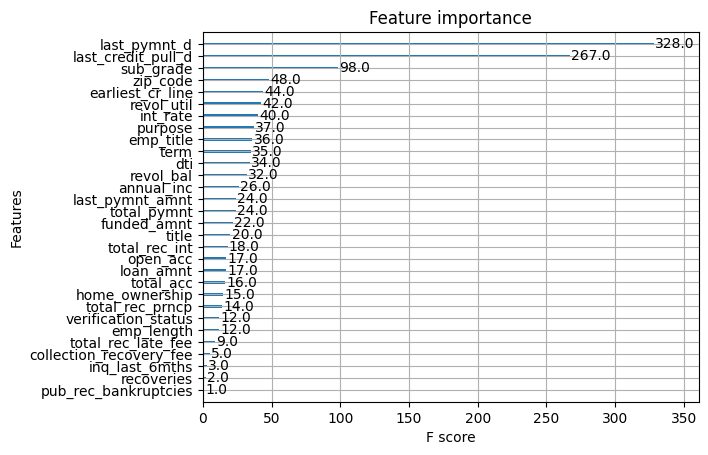

{'loan_amnt': 17.0, 'funded_amnt': 22.0, 'int_rate': 40.0, 'emp_length': 12.0, 'annual_inc': 26.0, 'dti': 34.0, 'inq_last_6mths': 3.0, 'open_acc': 17.0, 'revol_bal': 32.0, 'revol_util': 42.0, 'total_acc': 16.0, 'total_pymnt': 24.0, 'total_rec_prncp': 14.0, 'total_rec_int': 18.0, 'total_rec_late_fee': 9.0, 'recoveries': 2.0, 'collection_recovery_fee': 5.0, 'last_pymnt_amnt': 24.0, 'pub_rec_bankruptcies': 1.0, 'term': 35.0, 'sub_grade': 98.0, 'emp_title': 36.0, 'home_ownership': 15.0, 'verification_status': 12.0, 'purpose': 37.0, 'title': 20.0, 'zip_code': 48.0, 'earliest_cr_line': 44.0, 'last_pymnt_d': 328.0, 'last_credit_pull_d': 267.0}


In [65]:
# Vẽ biểu đồ feature importance
xgb.plot_importance(XGmodel_optimized, importance_type='weight')  # 'weight', 'gain', 'cover'
plt.show()

# In ra feature importance
importance = XGmodel_optimized.get_booster().get_score(importance_type='weight')
print(importance)

khá giống với decision tree

In [66]:
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                    Feature  Importance
28             last_pymnt_d       328.0
29       last_credit_pull_d       267.0
20                sub_grade        98.0
26                 zip_code        48.0
27         earliest_cr_line        44.0
9                revol_util        42.0
2                  int_rate        40.0
24                  purpose        37.0
21                emp_title        36.0
19                     term        35.0
5                       dti        34.0
8                 revol_bal        32.0
4                annual_inc        26.0
11              total_pymnt        24.0
17          last_pymnt_amnt        24.0
1               funded_amnt        22.0
25                    title        20.0
13            total_rec_int        18.0
0                 loan_amnt        17.0
7                  open_acc        17.0
10                total_acc        16.0
22           home_ownership        15.0
12          total_rec_prncp        14.0
23      verification_status        12.0


In [69]:
#
top_4_features = importance_df.head(4)
top_6_features = importance_df.head(6)

print("Top 4 Features:")
print(top_4_features)

print("\nTop 6 Features:")
print(top_6_features)

Top 4 Features:
               Feature  Importance
28        last_pymnt_d       328.0
29  last_credit_pull_d       267.0
20           sub_grade        98.0
26            zip_code        48.0

Top 6 Features:
               Feature  Importance
28        last_pymnt_d       328.0
29  last_credit_pull_d       267.0
20           sub_grade        98.0
26            zip_code        48.0
27    earliest_cr_line        44.0
9           revol_util        42.0


In [71]:
# Lấy danh sách các feature từ selected_features
selected_feature_names_top_4 = top_4_features['Feature'].tolist()

# Lọc X_train chỉ giữ lại các feature trong selected_feature_names
X_train_selected_top4 = X_train[selected_feature_names_top_4]
X_val_selected_top4 = X_val[selected_feature_names_top_4]
X_test_selected_top4 = X_test[selected_feature_names_top_4]

# Hiển thị các cột đã được chọn
print(X_train_selected.columns)

Index(['last_pymnt_d', 'last_credit_pull_d', 'sub_grade', 'zip_code'], dtype='object')


In [73]:
# Lấy danh sách các feature từ selected_features
selected_feature_names_top_6 = top_6_features['Feature'].tolist()

# Lọc X_train chỉ giữ lại các feature trong selected_feature_names
X_train_selected_top6 = X_train[selected_feature_names_top_4]
X_val_selected_top6 = X_val[selected_feature_names_top_4]
X_test_selected_top6 = X_test[selected_feature_names_top_4]

# Hiển thị các cột đã được chọn
print(X_train_selected.columns)

Index(['last_pymnt_d', 'last_credit_pull_d', 'sub_grade', 'zip_code'], dtype='object')


#### TOP 4 feature

In [ ]:
# Huấn luyện mô hình với tập huấn luyện
XGmodel_optimized.fit(X_train_selected_top4, y_train, eval_set=[(X_val_selected_top4, y_val)], verbose=True)

[0]	validation_0-logloss:0.71233
[1]	validation_0-logloss:0.70515
[2]	validation_0-logloss:0.69394
[3]	validation_0-logloss:0.67142
[4]	validation_0-logloss:0.65458
[5]	validation_0-logloss:0.63840
[6]	validation_0-logloss:0.62759
[7]	validation_0-logloss:0.62649
[8]	validation_0-logloss:0.62412
[9]	validation_0-logloss:0.62221
[10]	validation_0-logloss:0.61688
[11]	validation_0-logloss:0.61501
[12]	validation_0-logloss:0.61264
[13]	validation_0-logloss:0.60873
[14]	validation_0-logloss:0.60585
[15]	validation_0-logloss:0.60403
[16]	validation_0-logloss:0.60156
[17]	validation_0-logloss:0.60031
[18]	validation_0-logloss:0.59803
[19]	validation_0-logloss:0.59658
[20]	validation_0-logloss:0.59594
[21]	validation_0-logloss:0.59335
[22]	validation_0-logloss:0.59245
[23]	validation_0-logloss:0.59232
[24]	validation_0-logloss:0.59188
[25]	validation_0-logloss:0.59102
[26]	validation_0-logloss:0.59049
[27]	validation_0-logloss:0.59033
[28]	validation_0-logloss:0.59016
[29]	validation_0-loglos

In [77]:
y_val_pred = XGmodel_optimized.predict(X_val_selected_top4)

# Evaluate the model
print("Validation Set:")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))


Validation Set:
Confusion Matrix:
[[ 546  174]
 [1294 3140]]

Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.76      0.43       720
           1       0.95      0.71      0.81      4434

    accuracy                           0.72      5154
   macro avg       0.62      0.73      0.62      5154
weighted avg       0.86      0.72      0.76      5154


Accuracy Score:
0.7151726814124951
ROC AUC Score:
0.7332487595850248


#### Top 6 feature

In [78]:
# Huấn luyện mô hình với tập huấn luyện
XGmodel_optimized.fit(X_train_selected_top4, y_train, eval_set=[(X_val_selected_top6, y_val)], verbose=True)

[0]	validation_0-logloss:0.71233
[1]	validation_0-logloss:0.70515
[2]	validation_0-logloss:0.69394
[3]	validation_0-logloss:0.67142
[4]	validation_0-logloss:0.65458
[5]	validation_0-logloss:0.63840
[6]	validation_0-logloss:0.62759
[7]	validation_0-logloss:0.62649
[8]	validation_0-logloss:0.62412
[9]	validation_0-logloss:0.62221
[10]	validation_0-logloss:0.61688
[11]	validation_0-logloss:0.61501
[12]	validation_0-logloss:0.61264
[13]	validation_0-logloss:0.60873
[14]	validation_0-logloss:0.60585
[15]	validation_0-logloss:0.60403
[16]	validation_0-logloss:0.60156
[17]	validation_0-logloss:0.60031
[18]	validation_0-logloss:0.59803
[19]	validation_0-logloss:0.59658
[20]	validation_0-logloss:0.59594
[21]	validation_0-logloss:0.59335
[22]	validation_0-logloss:0.59245
[23]	validation_0-logloss:0.59232
[24]	validation_0-logloss:0.59188
[25]	validation_0-logloss:0.59102
[26]	validation_0-logloss:0.59049
[27]	validation_0-logloss:0.59033
[28]	validation_0-logloss:0.59016
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5563395147691081, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=3.2763280467895934,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0970049026111899,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=880, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [80]:
y_val_pred = XGmodel_optimized.predict(X_val_selected_top6)

# Evaluate the model
print("Validation Set:")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))

Validation Set:
Confusion Matrix:
[[ 546  174]
 [1294 3140]]

Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.76      0.43       720
           1       0.95      0.71      0.81      4434

    accuracy                           0.72      5154
   macro avg       0.62      0.73      0.62      5154
weighted avg       0.86      0.72      0.76      5154


Accuracy Score:
0.7151726814124951
ROC AUC Score:
0.7332487595850248


#### All feature

In [81]:
# Huấn luyện mô hình với tập huấn luyện
XGmodel_optimized.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)


[0]	validation_0-logloss:0.70501
[1]	validation_0-logloss:0.69622
[2]	validation_0-logloss:0.67614
[3]	validation_0-logloss:0.66211
[4]	validation_0-logloss:0.65369
[5]	validation_0-logloss:0.64831
[6]	validation_0-logloss:0.63901
[7]	validation_0-logloss:0.62766
[8]	validation_0-logloss:0.62026
[9]	validation_0-logloss:0.61776
[10]	validation_0-logloss:0.61681
[11]	validation_0-logloss:0.61490
[12]	validation_0-logloss:0.60786
[13]	validation_0-logloss:0.60483
[14]	validation_0-logloss:0.60361
[15]	validation_0-logloss:0.59977
[16]	validation_0-logloss:0.59135
[17]	validation_0-logloss:0.58574
[18]	validation_0-logloss:0.58428
[19]	validation_0-logloss:0.58136
[20]	validation_0-logloss:0.57934
[21]	validation_0-logloss:0.57142
[22]	validation_0-logloss:0.57020
[23]	validation_0-logloss:0.57088
[24]	validation_0-logloss:0.57011
[25]	validation_0-logloss:0.56952
[26]	validation_0-logloss:0.56867
[27]	validation_0-logloss:0.55841
[28]	validation_0-logloss:0.55693
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5563395147691081, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=3.2763280467895934,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0970049026111899,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=880, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [83]:
y_val_pred = XGmodel_optimized.predict(X_val)

# Evaluate the model
print("Validation Set:")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))

Validation Set:
Confusion Matrix:
[[ 546  174]
 [ 971 3463]]

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.76      0.49       720
           1       0.95      0.78      0.86      4434

    accuracy                           0.78      5154
   macro avg       0.66      0.77      0.67      5154
weighted avg       0.87      0.78      0.81      5154


Accuracy Score:
0.7778424524641055
ROC AUC Score:
0.7696718538565629


Có thể thấy XGBoost là 1 model phức tạp tận dụng được hết các feature

In [85]:
threshold = 10
selected_features = importance_df[importance_df['Importance'] > threshold]
selected_features

,Feature,Importance
28,last_pymnt_d,328.0
29,last_credit_pull_d,267.0
20,sub_grade,98.0
26,zip_code,48.0
27,earliest_cr_line,44.0
9,revol_util,42.0
2,int_rate,40.0
24,purpose,37.0
21,emp_title,36.0
19,term,35.0


In [89]:
# Lấy danh sách các feature từ selected_features
selected_feature = selected_features['Feature'].tolist()

# Lọc X_train chỉ giữ lại các feature trong selected_feature
X_train_selected = X_train[selected_feature]
X_val_selected = X_val[selected_feature]
X_test_selected = X_test[selected_feature]



In [91]:
# Huấn luyện mô hình với tập huấn luyện
XGmodel_optimized.fit(X_train_selected, y_train, eval_set=[(X_val_selected, y_val)], verbose=True)


[0]	validation_0-logloss:0.70639
[1]	validation_0-logloss:0.69688
[2]	validation_0-logloss:0.68942
[3]	validation_0-logloss:0.67521
[4]	validation_0-logloss:0.66933
[5]	validation_0-logloss:0.66273
[6]	validation_0-logloss:0.65363
[7]	validation_0-logloss:0.64603
[8]	validation_0-logloss:0.63660
[9]	validation_0-logloss:0.63326
[10]	validation_0-logloss:0.62419
[11]	validation_0-logloss:0.62221
[12]	validation_0-logloss:0.60797
[13]	validation_0-logloss:0.60169
[14]	validation_0-logloss:0.60048
[15]	validation_0-logloss:0.59531
[16]	validation_0-logloss:0.58991
[17]	validation_0-logloss:0.58802
[18]	validation_0-logloss:0.58662
[19]	validation_0-logloss:0.58460
[20]	validation_0-logloss:0.57446
[21]	validation_0-logloss:0.57211
[22]	validation_0-logloss:0.57192
[23]	validation_0-logloss:0.56271
[24]	validation_0-logloss:0.56036
[25]	validation_0-logloss:0.55712
[26]	validation_0-logloss:0.55577
[27]	validation_0-logloss:0.55315
[28]	validation_0-logloss:0.55326
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5563395147691081, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=3.2763280467895934,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0970049026111899,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=880, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [92]:
y_val_pred = XGmodel_optimized.predict(X_val_selected)

# Evaluate the model
print("Validation Set:")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))


Validation Set:
Confusion Matrix:
[[ 549  171]
 [1022 3412]]

Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.76      0.48       720
           1       0.95      0.77      0.85      4434

    accuracy                           0.77      5154
   macro avg       0.65      0.77      0.67      5154
weighted avg       0.87      0.77      0.80      5154


Accuracy Score:
0.7685292976329064
ROC AUC Score:
0.7660041723049165


Thế nên feature selection là nên chọn hết

# 4. Explainability

In [ ]:
decision_tree_model = dt_model
logistic_model = logistic_regression
neural_network_model = model

# **GLOBAL EXPLAINABILTIY**

**decision tree**

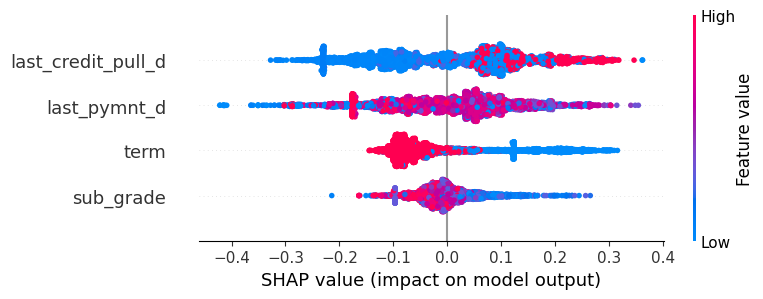

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.clf()
# SHAP values for Decision Tree
explainer_dt = shap.TreeExplainer(decision_tree_model,
                                  data=X_val_selected_dict['decision tree'])

shap_values_dt = explainer_dt.shap_values(X_val_selected_dict['decision tree'])

shap.summary_plot(shap_values_dt[:, :, 0],
                  X_val_selected_dict['decision tree'],
                  max_display=10)

plt.show()
display(plt.gcf())

**"last_credit_pull-d" :** ta nhận thấy rằng tiêu chí này thường, nếu giá trị thấp thì thường sẽ củng cố cho dự đoán lớp "0" - loan rejected (giảm khả năng được chấp thuận), về mặt ý nghĩa, thuộc tính này biểu thị cho việc nếu khách hàng đã yêu cầu khoản vay gần đây (dẫn tới giá trị của thuộc tính cao), thường có xu hướng tài chính kém ổn định hơn.

**Thuộc tính "last_pymnt_d" (tháng mà người vay đã thực hiện khoản thanh toán cuối cùng cho khoản vay của họ.):** hai thuộc tính này cũng có xu hướng tương tự khi chúng thể hiện việc tình trạng nợ hoặc khả năng trả nợ chưa tốt, trong khi thời gian xa hơn (giá trị thuộc tính sẽ thấp hơn) có thể phản ảnh tình trạng tài chính ổn định hơn.

Còn đối với hai tiêu chí "term" (kỳ hạn khoản vay) và "sub_grade" (xếp hạng tính dụng con) ít có đóng góp hơn vào sự dự đoán trong việc từ chối khoản vay, nhưng nhìn chung, nếu

**Logistic model**

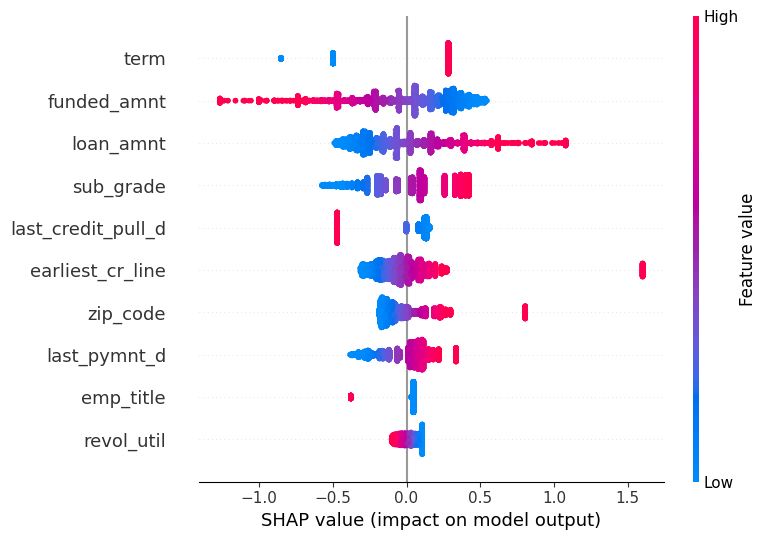

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.clf()
# SHAP values for Decision Tree
# explainer_dt = shap.LinearExplainer(logistic_model,
#                                   data = X_val_selected_dict['logistic'])
explainer_lr = shap.LinearExplainer(logistic_model,
                                    masker=shap.maskers.Independent(X_val_selected_dict['logistic']))

shap_values_lr = explainer_lr.shap_values(X_val_selected_dict['logistic'])

shap.summary_plot(shap_values_lr[:, :],
                  X_val_selected_dict['logistic'],
                  max_display=10)

plt.show()
display(plt.gcf())

Dựa vào "term", đây là feature có ảnh hưởng nhất đối với logistic model, chúng phản ánh việc các hồ sơ vay nếu có thời hạn dài hơn (36 tháng) thì thường có tỉ lệ được chấp nhận vay (loan approval) cao hơn so với các khoản vay ngắn hạn.

Dựa vào biểu đồ, ta thấy rằng hai tiêu chí "funded_amnt" và "loan_amnt" có ảnh hưởng tương đối đến việc loan rejection và loan approval. Nếu như "funded_amnt" càng lớn, tức người vay có nhu cầu tài chính cao hơn đi kèm với nhiều rủi ro hơn, thường có xu hướng dẫn đến loan rejected, còn ngược lại, với giá trị SHAP của loan_amnt có thể cho thấy rằng các khoản vay với số tiền yêu cầu cao hơn có thể được xem là hợp lý và có khả năng được chấp nhận. Điều này có thể giải thích tại sao giá trị SHAP của loan_amnt có thể dương và cao. Ngoài ra thì
Sub Grade (sub_grade): Phân loại phụ của khoản vay do LC gán - giá trị cao hơn có thể cho thấy người vay có hồ sơ tín dụng tốt hơn.

Ngoài ra các tiêu chí như (last_credit_pull_d), (earliest_cr_line), (zip_code), (last_pymnt_d), (emp_title), (revol_util) cũng cố các thông tin về củng cố liên quan đến người vay :      

1. Last Credit Pull Date (last_credit_pull_d): Tháng gần nhất mà LC kiểm tra tín dụng của khoản vay này. Thông tin này có thể cho thấy tình trạng tài chính hiện tại của người vay.

2. Earliest Credit Line (earliest_cr_line): Tháng mà dòng tín dụng đầu tiên của người vay được mở. Giá trị cao hơn có thể cho thấy người vay có lịch sử tín dụng lâu dài hơn.

3. Zip Code (zip_code): Mã bưu điện của người vay. Thông tin này có thể được sử dụng để đánh giá rủi ro dựa trên vị trí địa lý.

4. Last Payment Date (last_pymnt_d): Tháng gần nhất mà khoản thanh toán đã được nhận. Thông tin này có thể cho thấy người vay có thực hiện thanh toán đúng hạn hay không.

5. Employment Title (emp_title): Chức danh công việc của người vay. Thông tin này có thể cho thấy mức độ ổn định trong công việc của người vay.

6. Revolving Utilization (revol_util): Tỷ lệ sử dụng tín dụng quay vòng. Giá trị cao hơn có thể cho thấy người vay đang sử dụng nhiều tín dụng hơn so với hạn mức tín dụng của họ.

**Neural Network**

In [ ]:
plt.clf()
model.eval()
# SHAP values for neural network
X_val_tripped = shap.sample(X_val_selected_dict['neural network'], 1000)
explainer_nn = shap.DeepExplainer(neural_network_model,
                                  data=shap.sample(X_val_tripped, 1000))

shap_values_nn = explainer_nn.shap_values(
    X_val_selected_dict["neural network"])

<Figure size 640x480 with 0 Axes>

In [ ]:
printed_X_val_selected = pd.DataFrame(
    X_val_selected_dict["neural network"].cpu().numpy(), columns=X_val.columns)

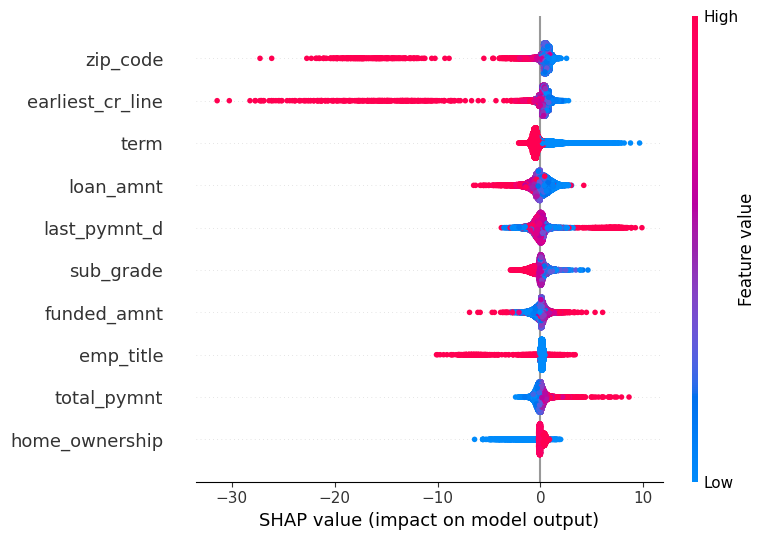

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.rcdefaults()
shap.summary_plot(shap_values_nn[:, :, 0],
                  printed_X_val_selected,
                  max_display=10)

plt.show()
display(plt.gcf())

Dựa vào biểu đồ, ta thấy được hai đặc trưng có đóng góp lớn trong việc dự đoán chính xác các đợt từ chối khoản vay, bao gồm:

**zip_code:** Đặc trưng này có phạm vi giá trị SHAP rộng, cho thấy ảnh hưởng đáng kể đến dự đoán của mô hình. Các giá trị cao của "zip_code" (màu đỏ) có xu hướng tác động tích cực, trong khi các giá trị thấp (màu xanh) có tác động tiêu cực.

**earliest_cr_line:** Tương tự như "zip_code", đặc trưng này cũng cho thấy phạm vi giá trị SHAP rộng, Khi dòng tín dụng đầu tiên được mở gần đây (giá trị thấp), khả năng bị từ chối khoản vay tăng lên một cách rõ ràng, và có hiệu quả hơn khi dự đoán được các phần từ chối khoản vay đúng. Ngược lại, khi dòng tín dụng đầu tiên được mở từ rất lâu (giá trị cao), khả năng bị từ chối khoản vay giảm xuống.

# **Local interpretability**

**Decision Tree**

In [ ]:
explain_value_dt = explainer_dt(X_val_selected_dict["decision tree"], y_val)

In [ ]:
random_idx = np.random.randint(1000)
random_idx

296

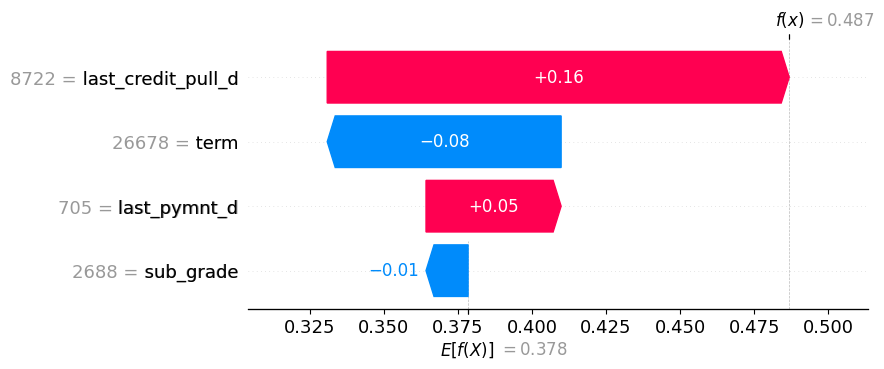

In [ ]:
shap.waterfall_plot(explain_value_dt[random_idx, :, 0])

**last_credit_pull_d (+0.16):**
Đây là đặc trưng có đóng góp lớn nhất và mang lại sự tăng giá trị dự đoán đáng kể.
Điều này có thể cho thấy mối quan hệ tích cực giữa đặc trưng này thời gian gần nhất yêu cầu vay và khả năng đạt được giá trị dự đoán cao hơn.

**term (-0.08):**
Đặc trưng này làm giảm giá trị dự đoán.
Điều này có thể chỉ ra rằng các điều khoản của khoản vay (như thời gian trả nợ dài hơn) có liên quan tiêu cực đến khả năng dự đoán.

**last_pymnt_d (+0.05):**
Đặc trưng này đóng góp nhỏ nhưng tích cực.
Có thể hiểu rằng thời gian gần đây khách hàng đã thanh toán khoản vay, từ đó tăng giá trị dự đoán.

**sub_grade (-0.01):**
Đặc trưng này có đóng góp nhỏ và tiêu cực, cho thấy mức phân loại tín dụng (sub_grade) không quá ảnh hưởng đến giá trị dự đoán trong trường hợp này, nhưng vẫn mang ý nghĩa rủi ro.

**Logistic model**

In [ ]:
explain_value_lr = explainer_lr(X_val_selected_dict["logistic"])

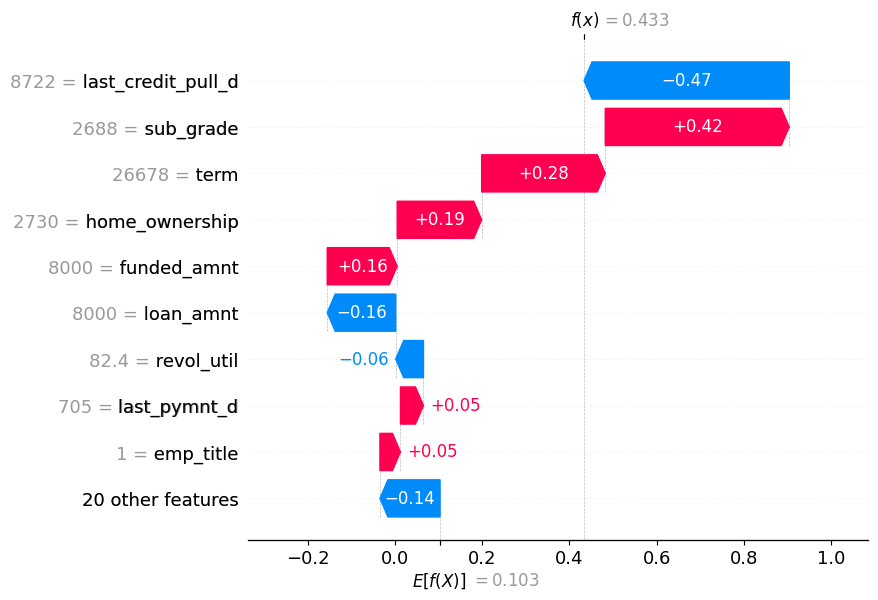

In [ ]:
shap.waterfall_plot(explain_value_lr[random_idx, :, 0])

**last_credit_pull_d:**  với giá trị SHAP là -0.47 (giảm đáng kể giá trị dự đoán), về ý nghĩa rằng lần gần nhất yêu cầu khoảng vay đã lâu, tức tài tình hình tài chính của khách hàng mẫu có thể ổn định, từ đó gia giảm cho giả thuyết nên từ chối khoản vay.

**sub_grade:** với giá trị SHAP +0.42 (tăng đáng kể giá trị dự đoán). Dễ thấy nếu sub_grade hay điểm rủi ro tăng cao thì càng cũng cố cho việc nên từ chối khoản vay
Các đặc trưng khác như:
1. home_ownership (+0.28) cũng có tác động tích cực.
2. loan_amnt (-0.16) và revol_util (-0.06) làm giảm giá trị dự đoán.

